In [1]:
import os
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("./data/iris_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## EDA
In EDA (Exploratory Data Analysis) the goal is to characterise the data without going too in depth. This means looking at the format end how everything is encoded first. Many common issues already happen in this stage and have to be solved before the data can be used in modelling. 

For example, unintuitive naming of columns, unknown datatypes or size can cause significant problems. This all happens before we even take a look at the contents.

In this dataset we can see that there are 150 datapoints. For supervised learning, there are 4 variables `sepal_length, sepal_width, petal_length, petal_width` and a single target variable `species`. The datatypes are floating point numbers for the model variables and string for the label.

Each label is represented equally (50 datapoints of each), so the data is balanced.

In [12]:
print(f"There are {data.shape[0]} datapoints in the dataset,\n \
the model variables are {data.columns[:-1].to_list()},\n \
and the label is '{data.columns[-1]}'.\n \
The datatypes of each variable is {data.dtypes.to_list()}")

There are 150 datapoints in the dataset,
 the model variables are ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
 and the label is 'species'.
 The datatypes of each variable is [dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O')]


In [ ]:
print(data['species'].value_counts())

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


We can easily analyse the distribution of some common statistics by using the `DataFrame.describe()` method and some common DataFrame manipulation methods.

From this we can see that the mean and median are mostly the same for the variables, except for `petal_length`. This is something to keep in mind for later.

In [22]:
# Get common statistics
data_stats = data.describe()
# Calculate the range for each model variable
data_stats.loc['range'] = data_stats.loc['max'] - data_stats.loc['min']
# Only grab the columns we want to use
data_stats = data_stats.loc[['mean', '25%', '50%', '75%', 'range']]
# Rename the 50% quantile to 'median'
data_stats.rename({'50%': 'median'}, inplace=True)
data_stats

,sepal_length,sepal_width,petal_length,petal_width
mean,5.843333,3.054,3.758667,1.198667
25%,5.100000,2.800,1.600000,0.300000
median,5.800000,3.000,4.350000,1.300000
75%,6.400000,3.300,5.100000,1.800000
range,3.600000,2.400,5.900000,2.400000


We can also calculate this per species, this will already give a lot of insight into what might become relevant later since the mean and overall distribution tells a lot about a dataset.

In [24]:
means = data.groupby('species').mean()
medians = data.groupby('species').median()
means, medians

(            sepal_length  sepal_width  petal_length  petal_width
 species                                                         
 setosa             5.006        3.418         1.464        0.244
 versicolor         5.936        2.770         4.260        1.326
 virginica          6.588        2.974         5.552        2.026,
             sepal_length  sepal_width  petal_length  petal_width
 species                                                         
 setosa               5.0          3.4          1.50          0.2
 versicolor           5.9          2.8          4.35          1.3
 virginica            6.5          3.0          5.55          2.0)

In [ ]:
data.groupby('species').aggregate(['mean', 'median'])

sepal_length        sepal_width        petal_length         \
                   mean median        mean median         mean median   
species                                                                 
setosa            5.006    5.0       3.418    3.4        1.464   1.50   
versicolor        5.936    5.9       2.770    2.8        4.260   4.35   
virginica         6.588    6.5       2.974    3.0        5.552   5.55   

           petal_width         
                  mean median  
species                        
setosa           0.244    0.2  
versicolor       1.326    1.3  
virginica        2.026    2.0

From this we can already see that the mean values are quite different between categories. So it will probably be relatively easy to learn for a model which label is correct. However, to really know this we need to look at a more detailed distribution.

In [27]:
import matplotlib.pyplot as plt

[Text(0.5, 0, 'Sepal Length (cm)'),
 Text(0, 0.5, 'Sepal Width (cm)'),
 Text(0.5, 1.0, 'Sepal Length vs Width')]

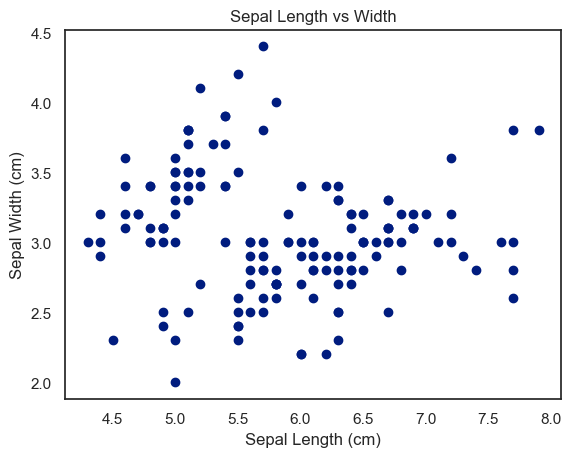

In [102]:
ax = plt.axes()
ax.scatter(data['sepal_length'], data['sepal_width'])
ax.set(xlabel='Sepal Length (cm)',
       ylabel='Sepal Width (cm)',
       title='Sepal Length vs Width')

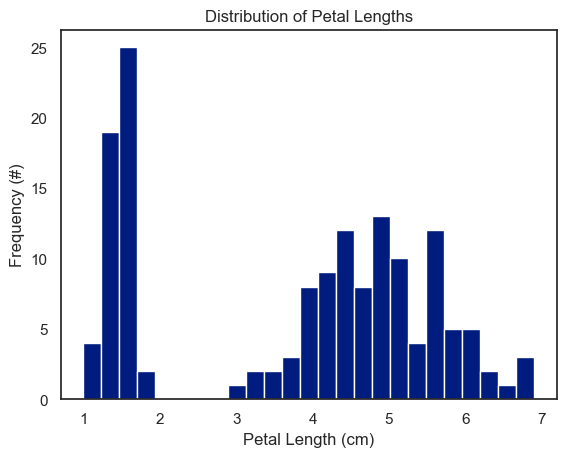

In [101]:
ax = data['petal_length'].plot.hist(bins=25)
ax.set_xlabel('Petal Length (cm)')
ax.set_ylabel('Frequency (#)')
ax.set_title('Distribution of Petal Lengths');

Text(0.5, 0, 'Size (cm)')

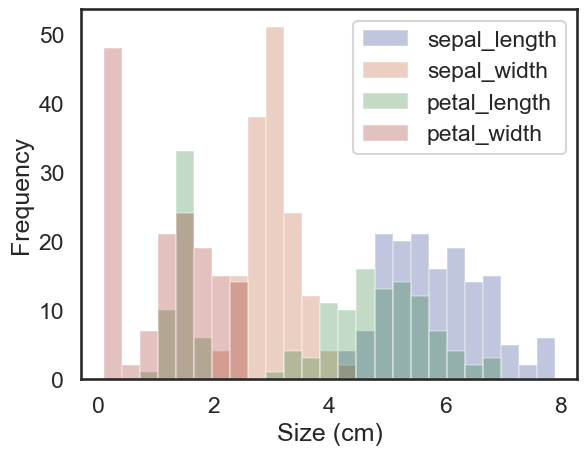

In [99]:
ax = data.plot.hist(bins=25, alpha=0.25)
ax.set_xlabel("Size (cm)")

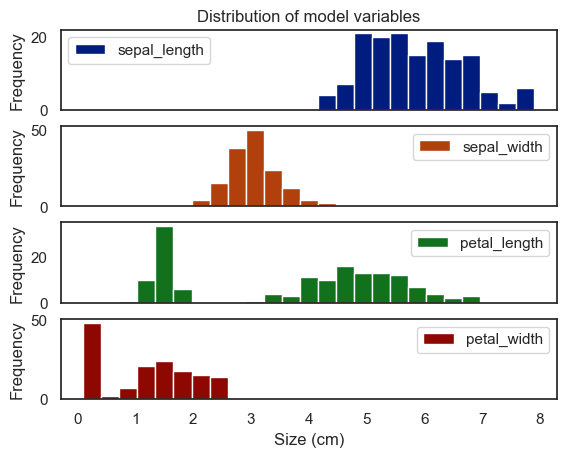

In [100]:
import seaborn as sns
sns.set_context('notebook')
ax = data[:-1].plot.hist(bins=25, subplots=True)
ax[-1].set_xlabel("Size (cm)")
ax[0].set_title('Distribution of model variables');

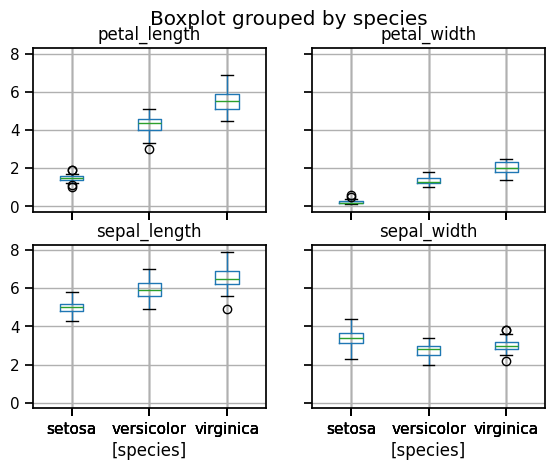

In [62]:
data.boxplot(by="species");

Seaborn can be used to create a nice boxplot that clearly shows each category color coded. For this we need to transform the data so that there is only a single data point per row. Seaborn will aggregate this for the plot.

To get to this point, we first set the index to the species column, this makes each row associated with its label instead of the default integer index. Then we can stack the dataframe, which results in a multi-index Series, which can be converted back to a multi-index dataframe. This can be flattened to a single level dataframe indexed by an integer again. Due to this the second level of the index (which is a combination of all columns from before), must be renamed.

This essentially 'unrolls' the entire dataset such that each datapoint is contained in a single column 'measurement'. By inspection of the shape this makes sense; 4 variables * 150 datapoints = 600 measurements.

#### Documentation:
- [Seaborn Boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)
- [Pandas DataFrame.stack()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.stack.html)

In [87]:
boxplot_sns_data = (
    data
    .set_index('species')
    .stack() # To multiindex Series
    .to_frame() # To multiindex DF
    .reset_index() # Revert to single index DF
    .rename(columns={0:'size', 'level_1':'measurement'}) # Set name to insightful name
)
boxplot_sns_data.shape

(600, 3)

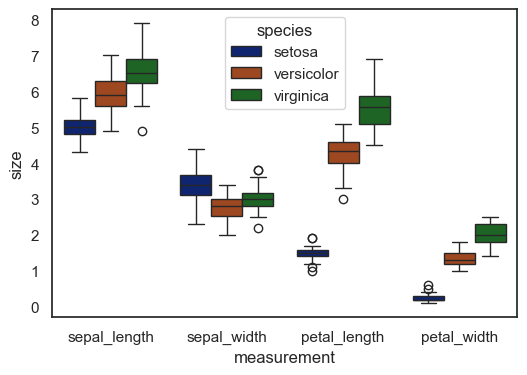

In [94]:
sns.set_style('white')
sns.set_context('notebook')
sns.set_palette('dark')

f = plt.figure(figsize=(6, 4))
sns.boxplot(x='measurement', y='size', hue='species', data=boxplot_sns_data);

This clearly shows that every variable, except `sepal_width` has nice separation and a clear trend associated with the category. `sepal_length` might cause some trouble later, so again something to keep in mind.

Finally, we can create a pairplot to check for correlations. Seaborn makes this very easy.

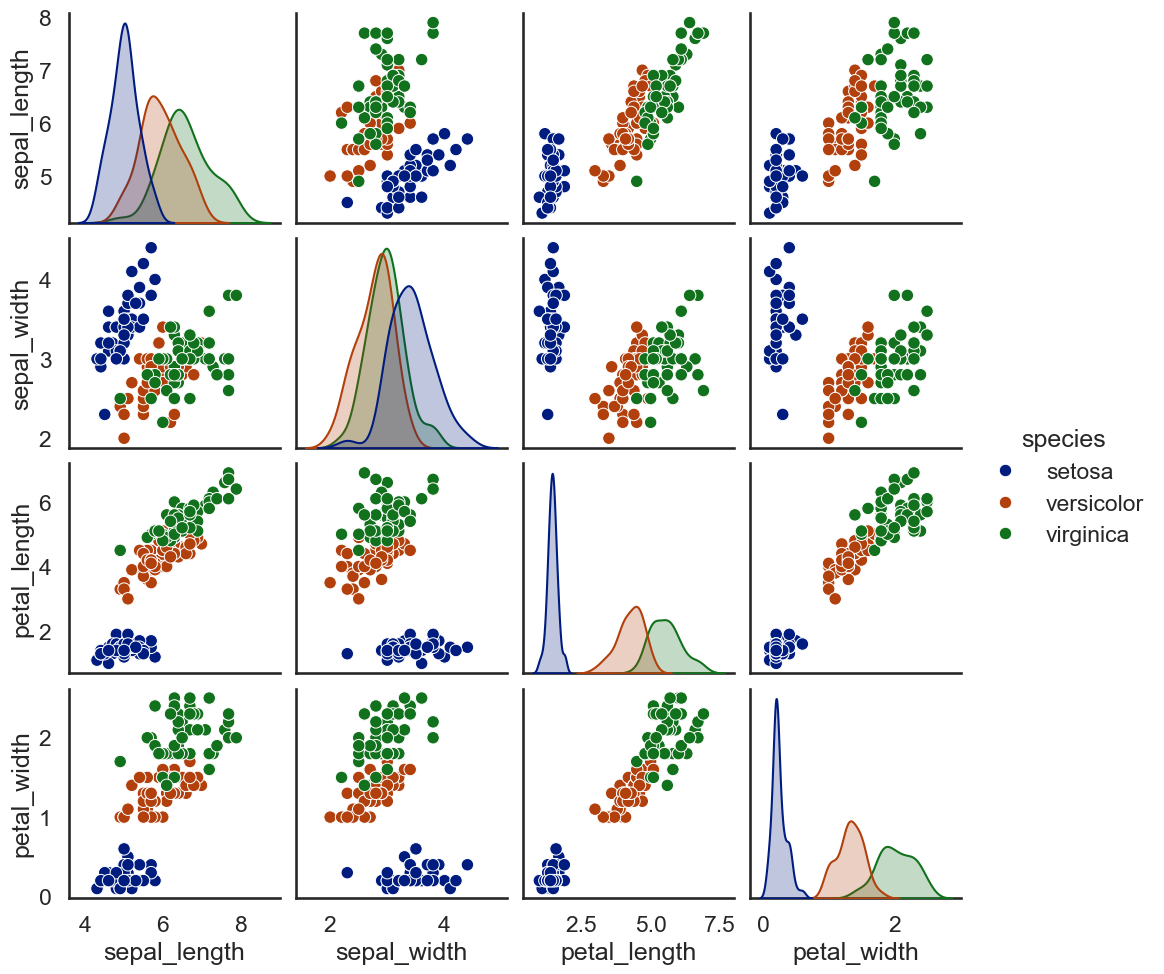

In [96]:
sns.set_context('talk')
sns.pairplot(data=data, hue='species');